In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
mpl.rcParams['image.cmap'] = 'gray'
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)
pred = model(x_train)

## Implement cross-entropy loss

In [7]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [8]:
sm_pred = log_softmax(pred)

In [9]:
y_train[:3], sm_pred[0][5]

(tensor([5, 0, 4]), tensor(-2.3939, grad_fn=<SelectBackward>))

In [10]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.3939, -2.3913, -2.2500], grad_fn=<IndexBackward>)

In [11]:
def nll(input, target): 
    # Selects the row in the prediction that matches the train target,
    # then takes the negative of it. 
    #  Assumes that the input is the log likelihood over all classes
    return -input[range(target.shape[0]), target].mean()

In [12]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3100, grad_fn=<NegBackward>)

In [13]:
def log_softmax(x): 
    # Keepdim maintains the dimension even though its summed over.
    return x - x.exp().sum(-1, keepdim=True).log()

In [14]:
test_near(nll(log_softmax(pred), y_train), loss)

In [15]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [16]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [17]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [18]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [19]:
test_near(F.cross_entropy(pred, y_train), loss)

## Code basic training loop

In [20]:
loss_func = F.cross_entropy

In [21]:
#export
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [22]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.0373, -0.2003,  0.0945,  0.0655, -0.0123, -0.0953,  0.0281, -0.0026,
          0.1663, -0.0960], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [23]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3082, grad_fn=<NllLossBackward>)

In [24]:
accuracy(preds, yb)

tensor(0.0625)

In [25]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [26]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [27]:
l = loss_func(model(xb), yb), accuracy(model(xb), yb)
l

(tensor(0.0697, grad_fn=<NllLossBackward>), tensor(1.))

# Parameters and optim

## Parameters

In [28]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [29]:
model = Model(m, nh, 10)

In [30]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [31]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [32]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0962, grad_fn=<NllLossBackward>), tensor(0.9375))

In [34]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [35]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [36]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering Modules


In [37]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [40]:
#pytorch's set_attr will not work if the layers come as a list. We have to add modules. 
# If we made a model that wrapped the list of layers though it would be ok.. 

class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x
    

In [39]:
model = Model(layers)

In [41]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## ModuleList
We could just use ModuleList instead

In [42]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [43]:
model = SequentialModel(layers)

In [44]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [45]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0456, grad_fn=<NllLossBackward>), tensor(1.))

## Conveniently we can use nn.Sequential

In [46]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [47]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0783, grad_fn=<NllLossBackward>), tensor(0.9375))

In [49]:
nn.Sequential??

## optim
lets use an optimizer

In [50]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [51]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(model.parameters())

In [52]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [53]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0298, grad_fn=<NllLossBackward>), tensor(1.))

In [54]:
#export
from torch import optim

In [55]:
optim.SGD.step??

In [56]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [57]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3113, grad_fn=<NllLossBackward>)

In [58]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [59]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1348, grad_fn=<NllLossBackward>), tensor(0.9375))

In [60]:
assert acc>0.7

## Dataset + Dataloader

In [63]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [65]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [66]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [67]:
model,opt = get_model()

In [68]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [69]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0481, grad_fn=<NllLossBackward>), tensor(1.))

## Dataloader

In [70]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

In [71]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [72]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

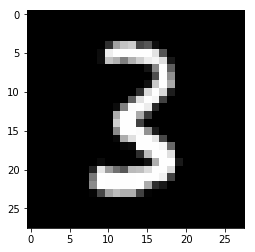

In [73]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [74]:
model,opt = get_model()

In [77]:
def fit():
    # Worryingly dependent upon lots of global variables...
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [78]:
fit()

In [79]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0303, grad_fn=<NllLossBackward>), tensor(1.))

## Random sampling

In [80]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): 
            yield self.idxs[i:i+self.bs]

In [81]:
small_ds = Dataset(*train_ds[:10])

In [82]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [83]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([8, 1, 0]), tensor([2, 6, 4]), tensor([9, 5, 3]), tensor([7])]

In [84]:
torch.stack?

In [87]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        # each sampler provides a set of indicies into the dataset
        for s in self.sampler: 
            # Each dataset when indexed [i] returns both the x and the y.
            # Not sure why we need to collate in this way... 
            yield self.collate_fn([self.ds[i] for i in s])
    
    

In [86]:
zip?

In [88]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [89]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

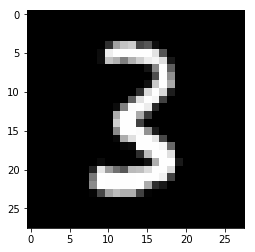

In [90]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(7)

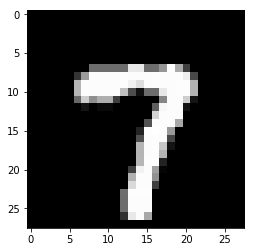

In [91]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [92]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1968, grad_fn=<NllLossBackward>), tensor(0.9531))

## Pytorch's dataloader

In [94]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [95]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [96]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1517, grad_fn=<NllLossBackward>), tensor(0.9688))

In [97]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2013, grad_fn=<NllLossBackward>), tensor(0.9375))

## Validation

In [99]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv